## Imports

In [92]:
import cv2
import pickle as pkl
from tqdm import tqdm
import matching_utils
import matplotlib.pyplot as plt

## Load detections

In [114]:
# Open the file in binary mode
seq = 'seq3'
cam = 'c15'

S = 'S03'
C = 'c015'

theshold = 0.25

with open(f'/home/group05/mcv-m6-2022-team5/week5/tracking_results/kalman_tracking_{seq}_{cam}_pp.pkl', 'rb') as file:
    # Call load method to deserialze
    detections = pkl.load(file)

video_path = f'/home/group05/mcv-m6-2022-team5/datasets/aic19-track1-mtmc-train/train/{S}/{C}/vdo.avi'

In [115]:
detections[1]

,frame,track,bbox,colour,size,detection,life


# Detections to global df

In [116]:
global_track_ids_df = matching_utils.init_global_track_ids_df()
model = matching_utils.get_metric_learning_model()

Using cache found in /home/group05/.cache/torch/hub/pytorch_vision_v0.10.0


In [117]:
vidcap = cv2.VideoCapture(video_path)

_, _ = vidcap.read()

for detection in tqdm(detections):
    _, image = vidcap.read()
    if type(image) != type(None):
        for index, row in detection.iterrows():
            if not row['track'] in global_track_ids_df['track_ids'].unique():
                global_track_ids_df = matching_utils.add_global_track_ids(global_track_ids_df, image, row)
            else:
                img = matching_utils.get_detected_box_image(image, row['bbox'])

                index = global_track_ids_df.index[global_track_ids_df['track_ids'] == row['track']].tolist()[0]
                detection_frames_list = global_track_ids_df.loc[index, 'detection_frames']

                distances = []

                for detection_frame in detection_frames_list:
                    distances.append(matching_utils.get_metric_distance(model, img, detection_frame)[0][1])

                if min(distances) > theshold:
                    global_track_ids_df = matching_utils.update_global_track_id(global_track_ids_df, image, row)

pkl.dump(global_track_ids_df, open(f"./matching_results/track_ids_df_{S}_{C}.pkl", "wb"))

100%|██████████| 1928/1928 [00:11<00:00, 170.75it/s]


In [118]:
with open(f"./matching_results/track_ids_df_{S}_{C}.pkl",'rb') as openFile:
    global_track_ids_df = pkl.load(openFile)

global_track_ids_df

,track_ids,detection_frames
0,44,"[[[[133 145 150], [ 99 111 116], [104 116 121]..."
1,68,"[[[[170 174 162], [170 174 162], [170 174 162]..."
2,59,"[[[[162 159 153], [162 159 153], [162 158 148]..."
3,91,"[[[[147 149 142], [147 149 142], [149 153 141]..."


3


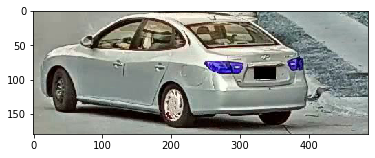

In [136]:
## good examples seq3-c013 7/8
index = 0
print(len(global_track_ids_df.loc[index,'detection_frames']))
plt.imshow(global_track_ids_df.loc[index,'detection_frames'][2])
plt.show()

# Global Matching